In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype
import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature
import time
import calendar

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# get lons and lats
# This will return the most recent data avail on mesonet
# this is my file path
ny_mesonet_data_path = "/home/aevans/nysm/archive/nysm/netcdf/proc"
ok_mesonet_data_path = "/home/aevans/landtype/geoinfo.csv"

In [4]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [5]:
gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    "12"
)

In [6]:
gfs_fcast_and_error_df.keys()

Index(['t2m_GFS', 'd2m_GFS', 'u_total_GFS', 'u_dir_GFS', 'latitude',
       'longitude', 'new_tp_GFS', 'prmsl_GFS', 'orog', 't2m_error',
       'd2m_error', 'u_total_error', 'u_dir_error', 'new_tp_error',
       'prmsl_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm', 'u_dir_nysm',
       'new_tp_nysm', 'prmsl_nysm', 'lead_time_DAY', 'lead_time_HOUR',
       'lead_time_ONLY_HOURS'],
      dtype='object')

In [7]:
def main(nwp_df, variable, n_clusters):
    df = nwp_df.reset_index()
    months_df = (
        df.groupby([df.time.dt.month, "station"])[variable]
        .mean()
        .to_frame()
        .reset_index()
    )
    features = months_df.pivot(index="station", columns="time", values=variable)
    features = features.reset_index()
    stations = features["station"].tolist()
    features = features.drop(columns=["station"])
    # noramalize data
    scaler = preprocessing.MinMaxScaler()
    features_normal = scaler.fit_transform(features)
    # kmeans clustering
    inertia = []
    K = range(1, 20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(features_normal)
        kmeanModel.fit(features_normal)
        inertia.append(kmeanModel.inertia_)
    # Plot the elbow
    plt.plot(K, inertia, "bx-")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.show()
    # do actual cluster run
    kmeans = KMeans(n_clusters=n_clusters).fit(features_normal)
    labels = pd.DataFrame(
        kmeans.labels_
    )  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
    labeledClasses = pd.concat((features, labels), axis=1)
    labeledClasses = labeledClasses.rename({0: "labels"}, axis=1)
    plot_df = pd.read_csv(
        "/home/aevans/nwp_bias/src/landtype/notebooks/nysm_coords.csv"
    )
    plot_df["Cluster"] = labels
    colors = [
        "black",
        "blue",
        "green",
        "red",
        "orange",
        "yellow",
        "white",
        "purple",
        "cyan",
        "plum",
        "coral",
        "pink",
    ]
    legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

    colordict = {}

    for x, _ in enumerate(colors):
        colordict.update({legend[x]: colors[x]})

    plot_df["color"] = plot_df["Cluster"].map(colordict)
    return plot_df

# K_means

In [8]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df["latitude"].max() + 1
    latS = df["latitude"].min() - 1
    lonW = df["longitude"].max() + 1
    lonE = df["longitude"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["longitude"],
        y=df["latitude"],
        c=df["color"],
        s=80,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

# Precipitation

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

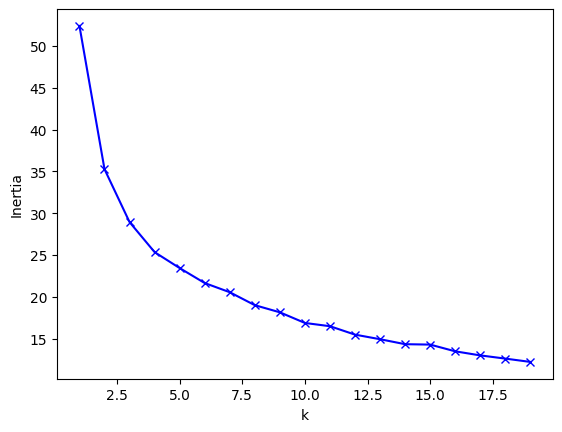

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
# Precip
plot_df = main(gfs_fcast_and_error_df, "new_tp_nysm", 4)

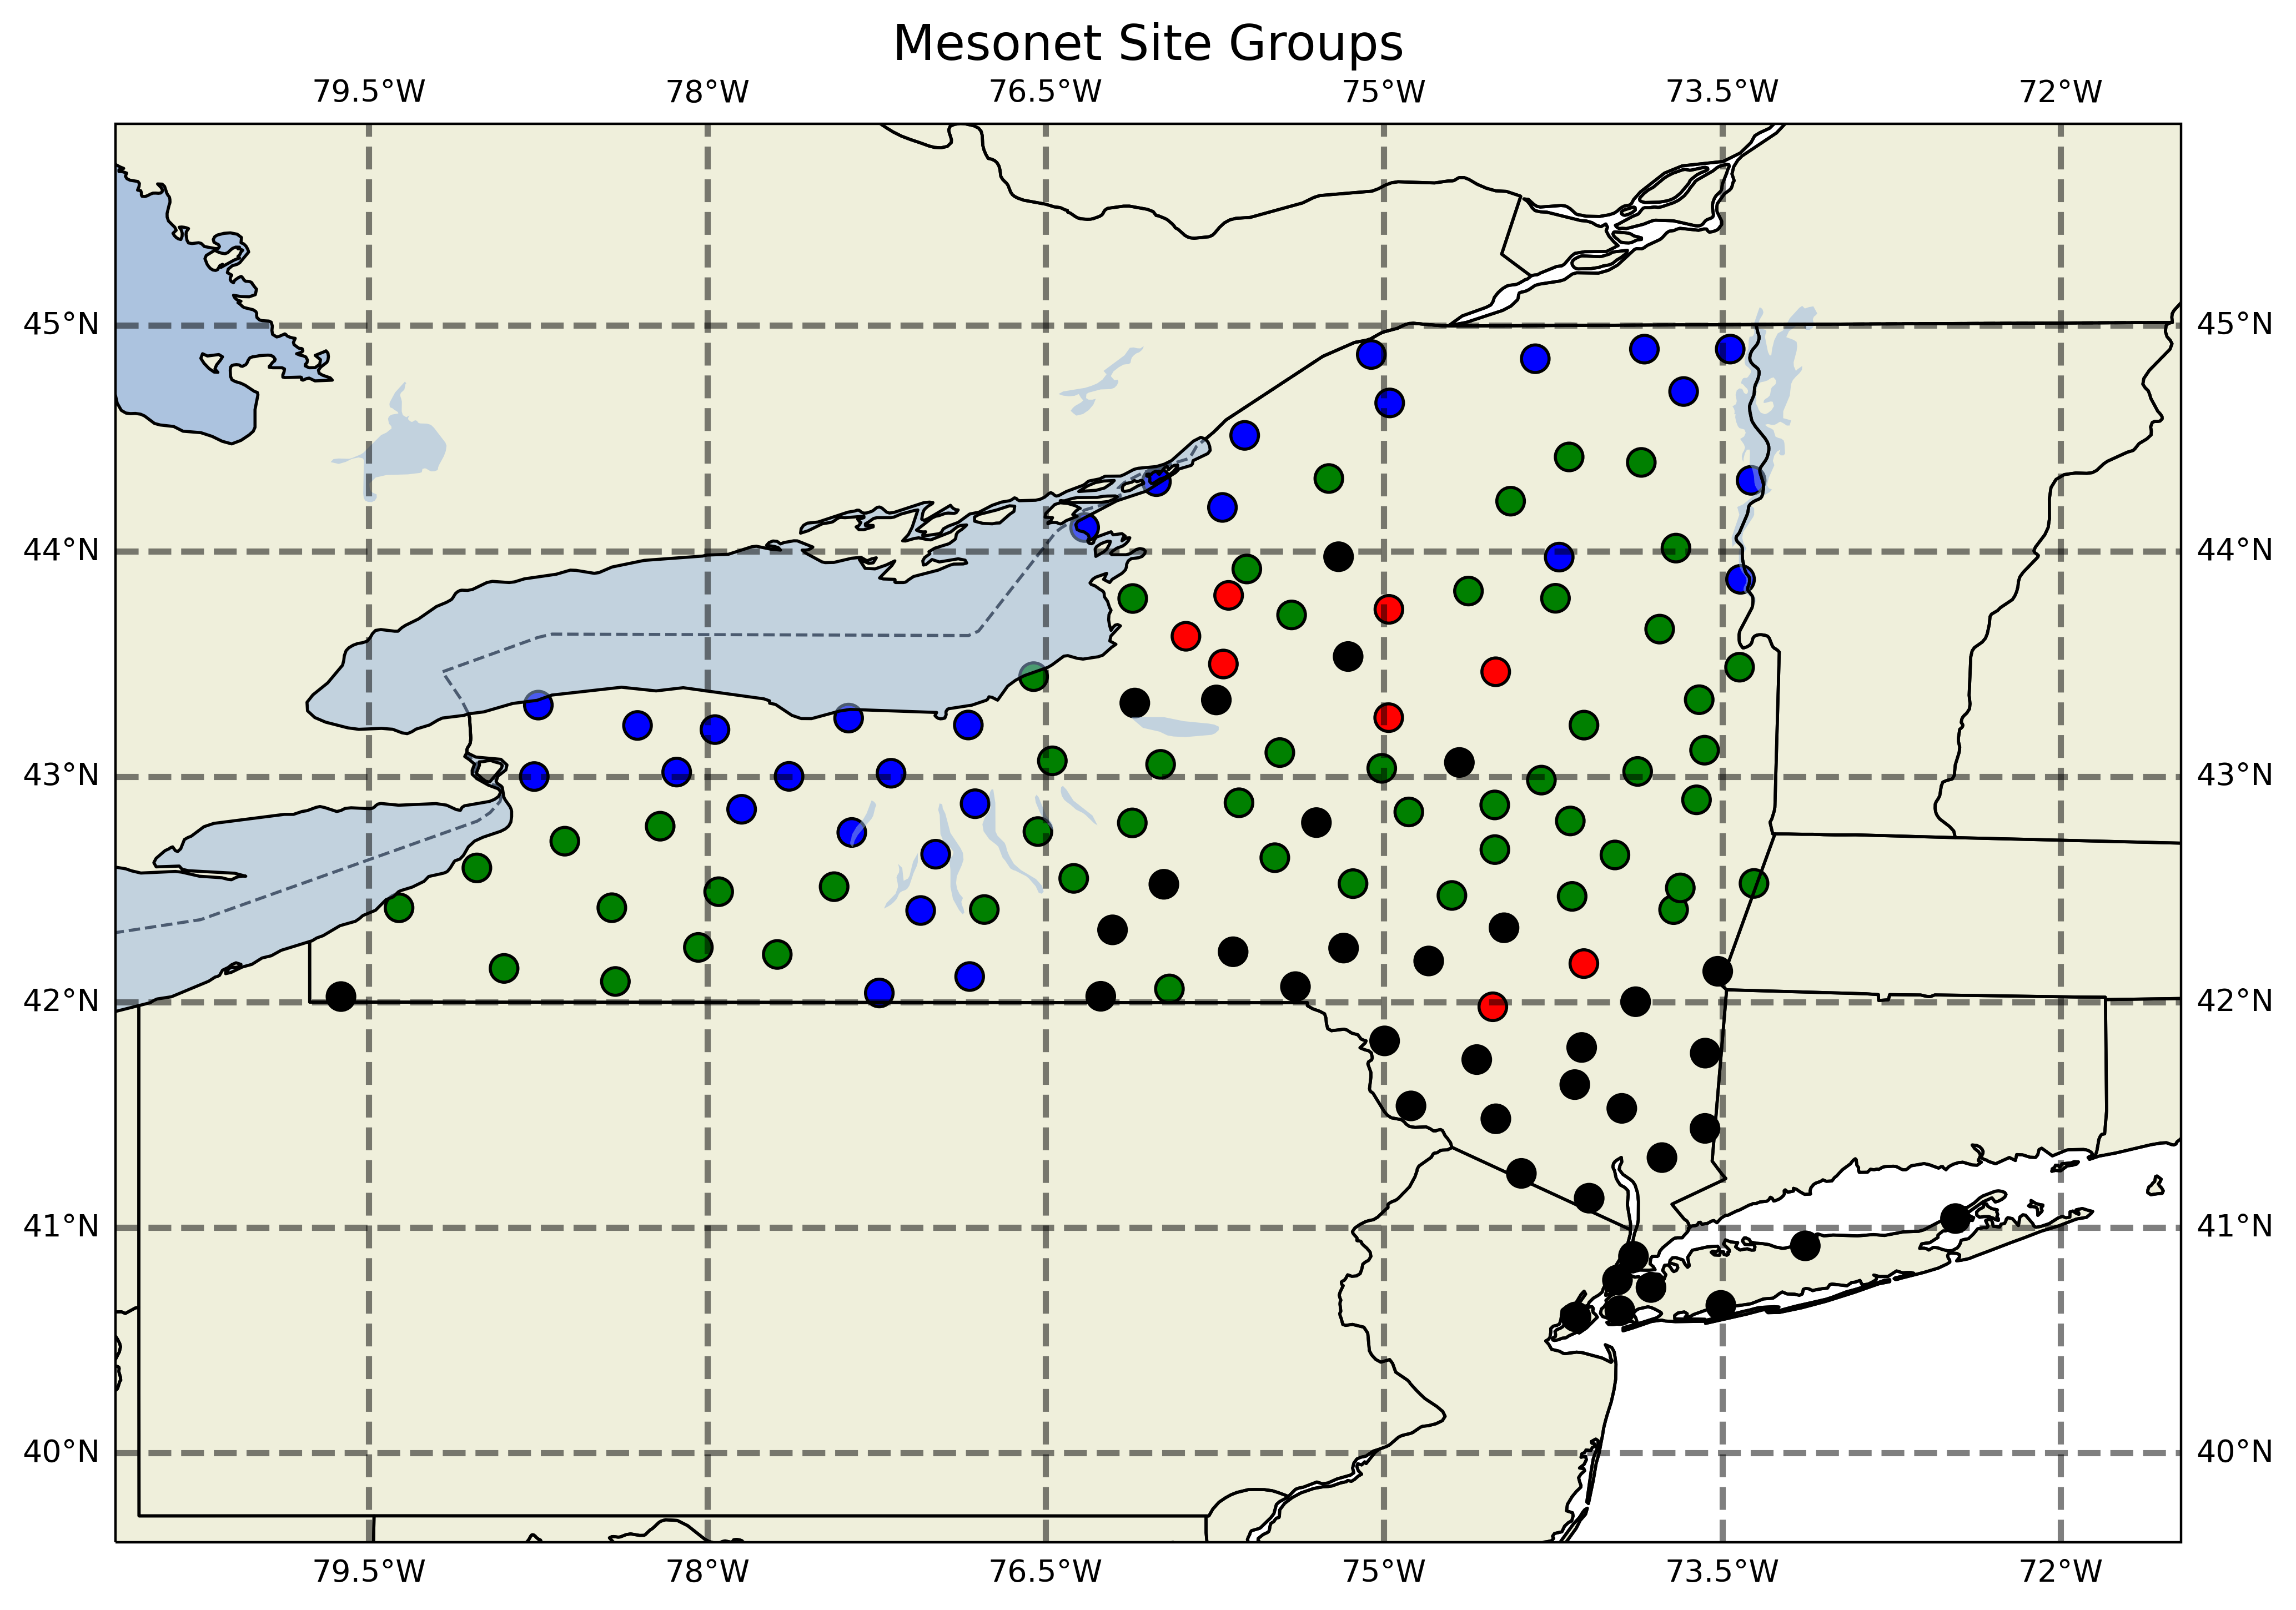

In [10]:
plurality_plot(plot_df)

# Temperature

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

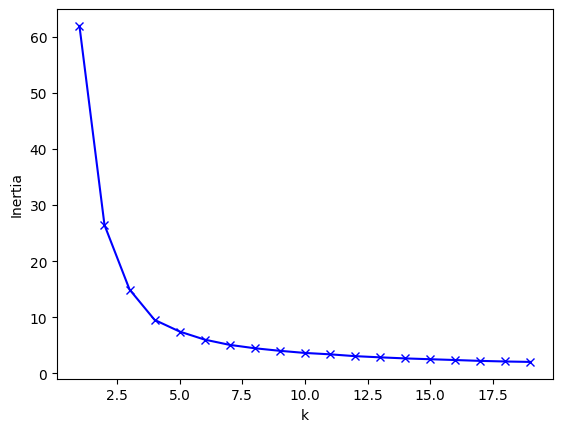

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


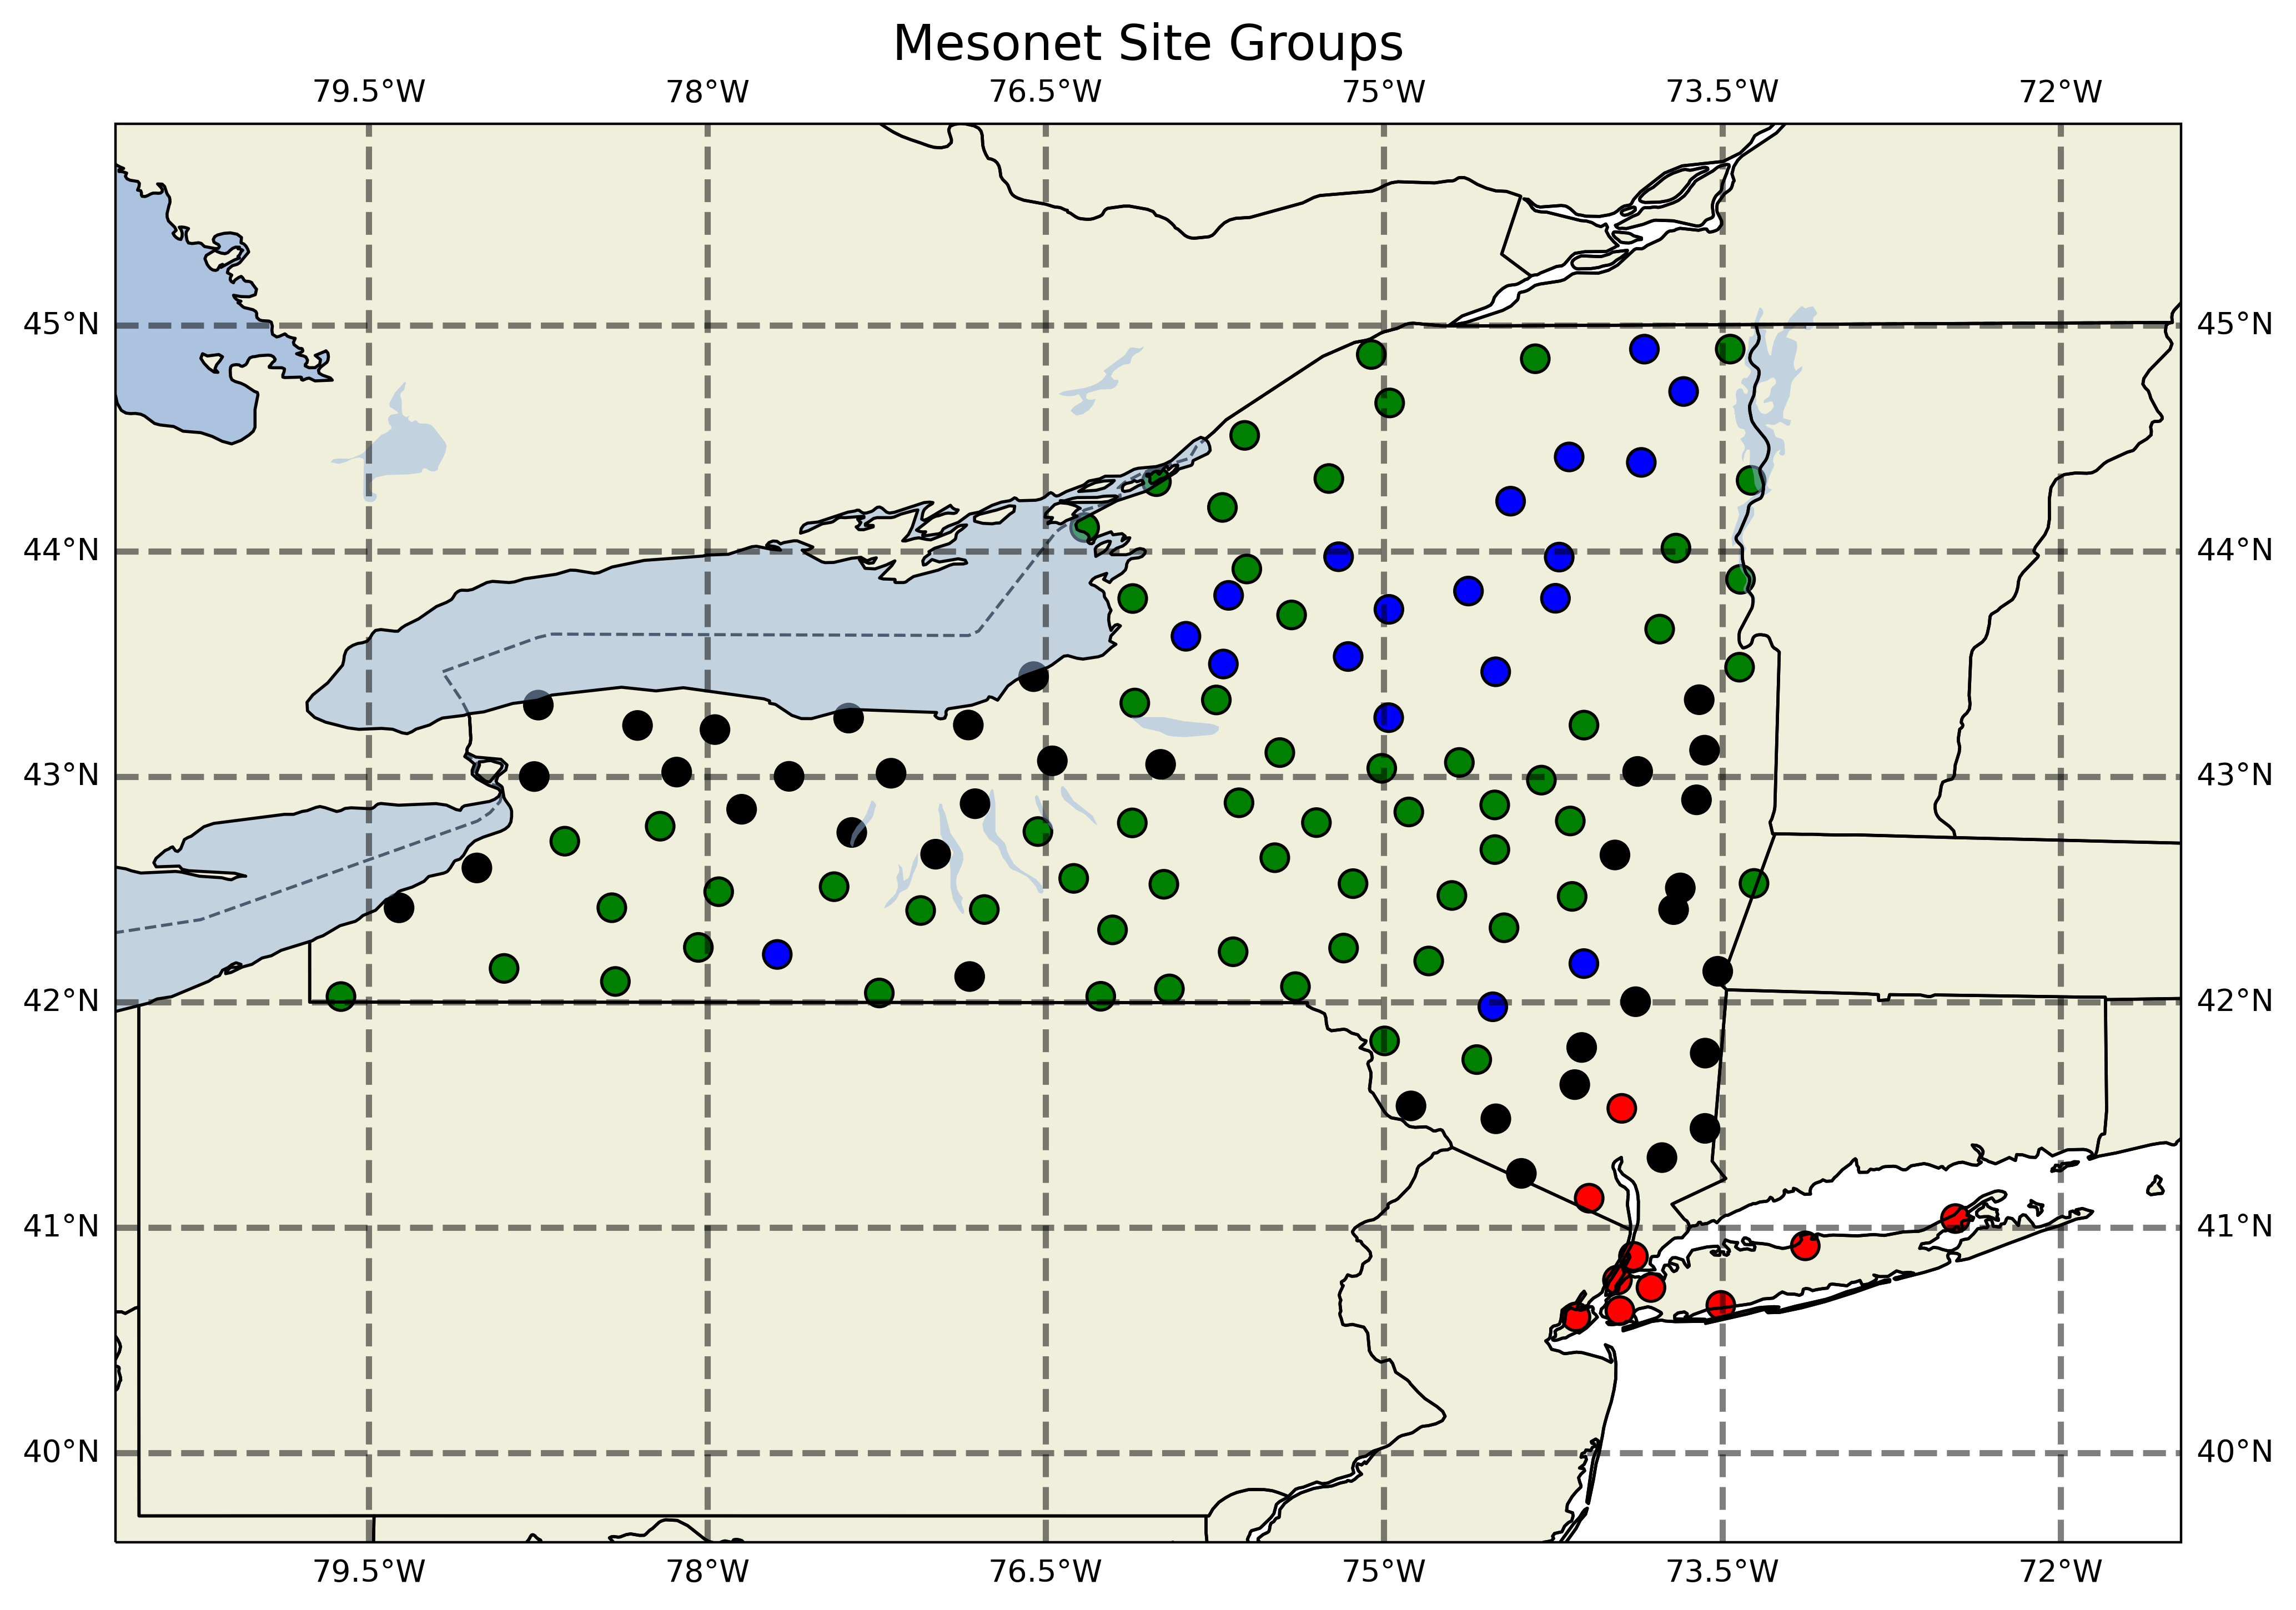

In [11]:
# temp
temp_df = main(gfs_fcast_and_error_df, "t2m_nysm", 4)
plurality_plot(temp_df)

# Wind Mag

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

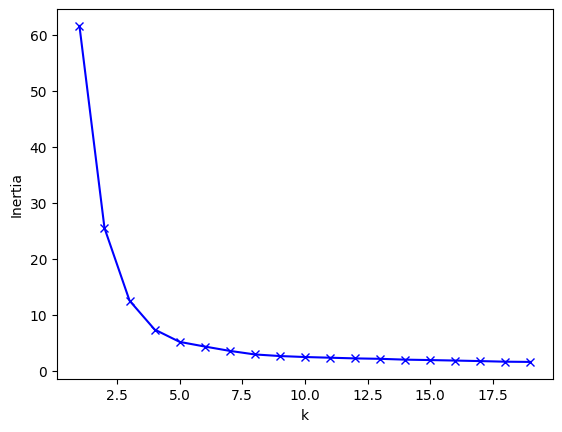

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
# wind
wind_df = main(gfs_fcast_and_error_df, "u_total_nysm", 4)

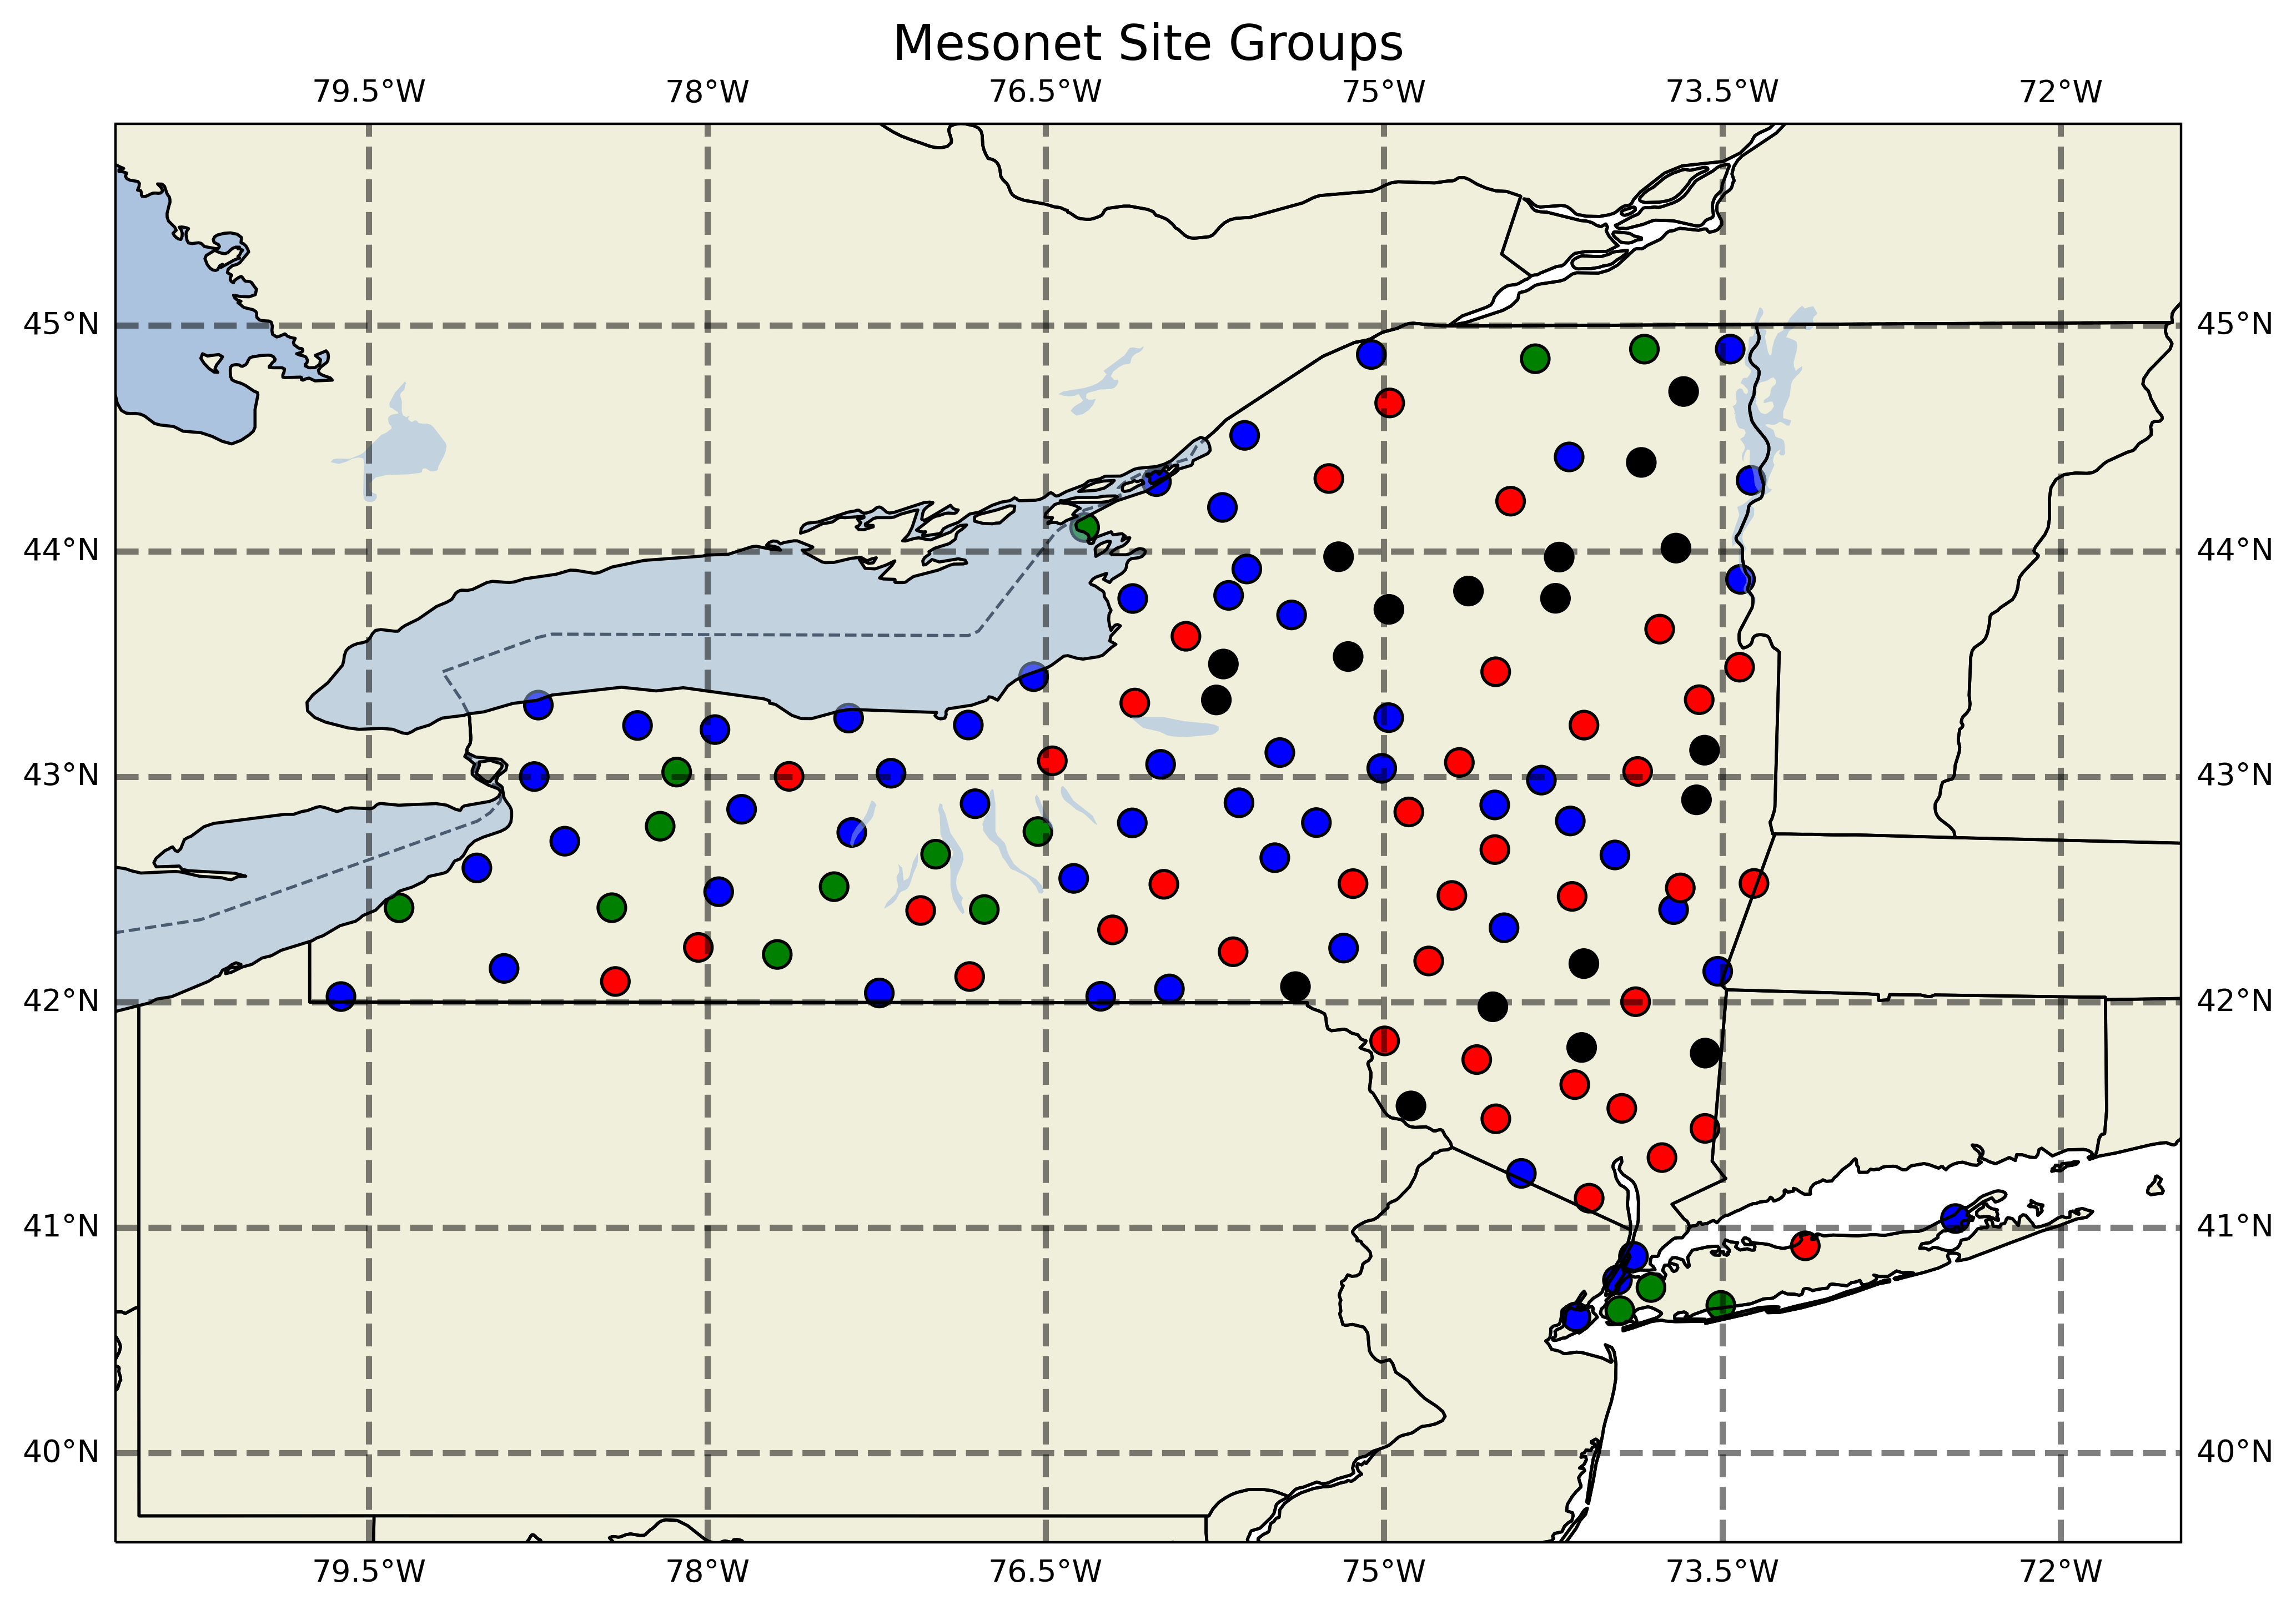

In [13]:
plurality_plot(wind_df)

# Pressure

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

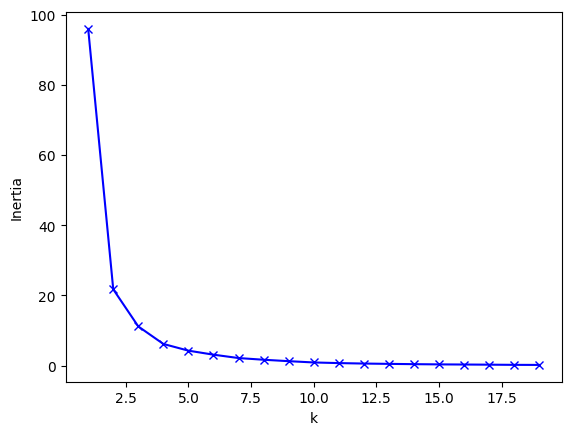

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
# pressure
pres_df = main(gfs_fcast_and_error_df, "prmsl_nysm", 4)

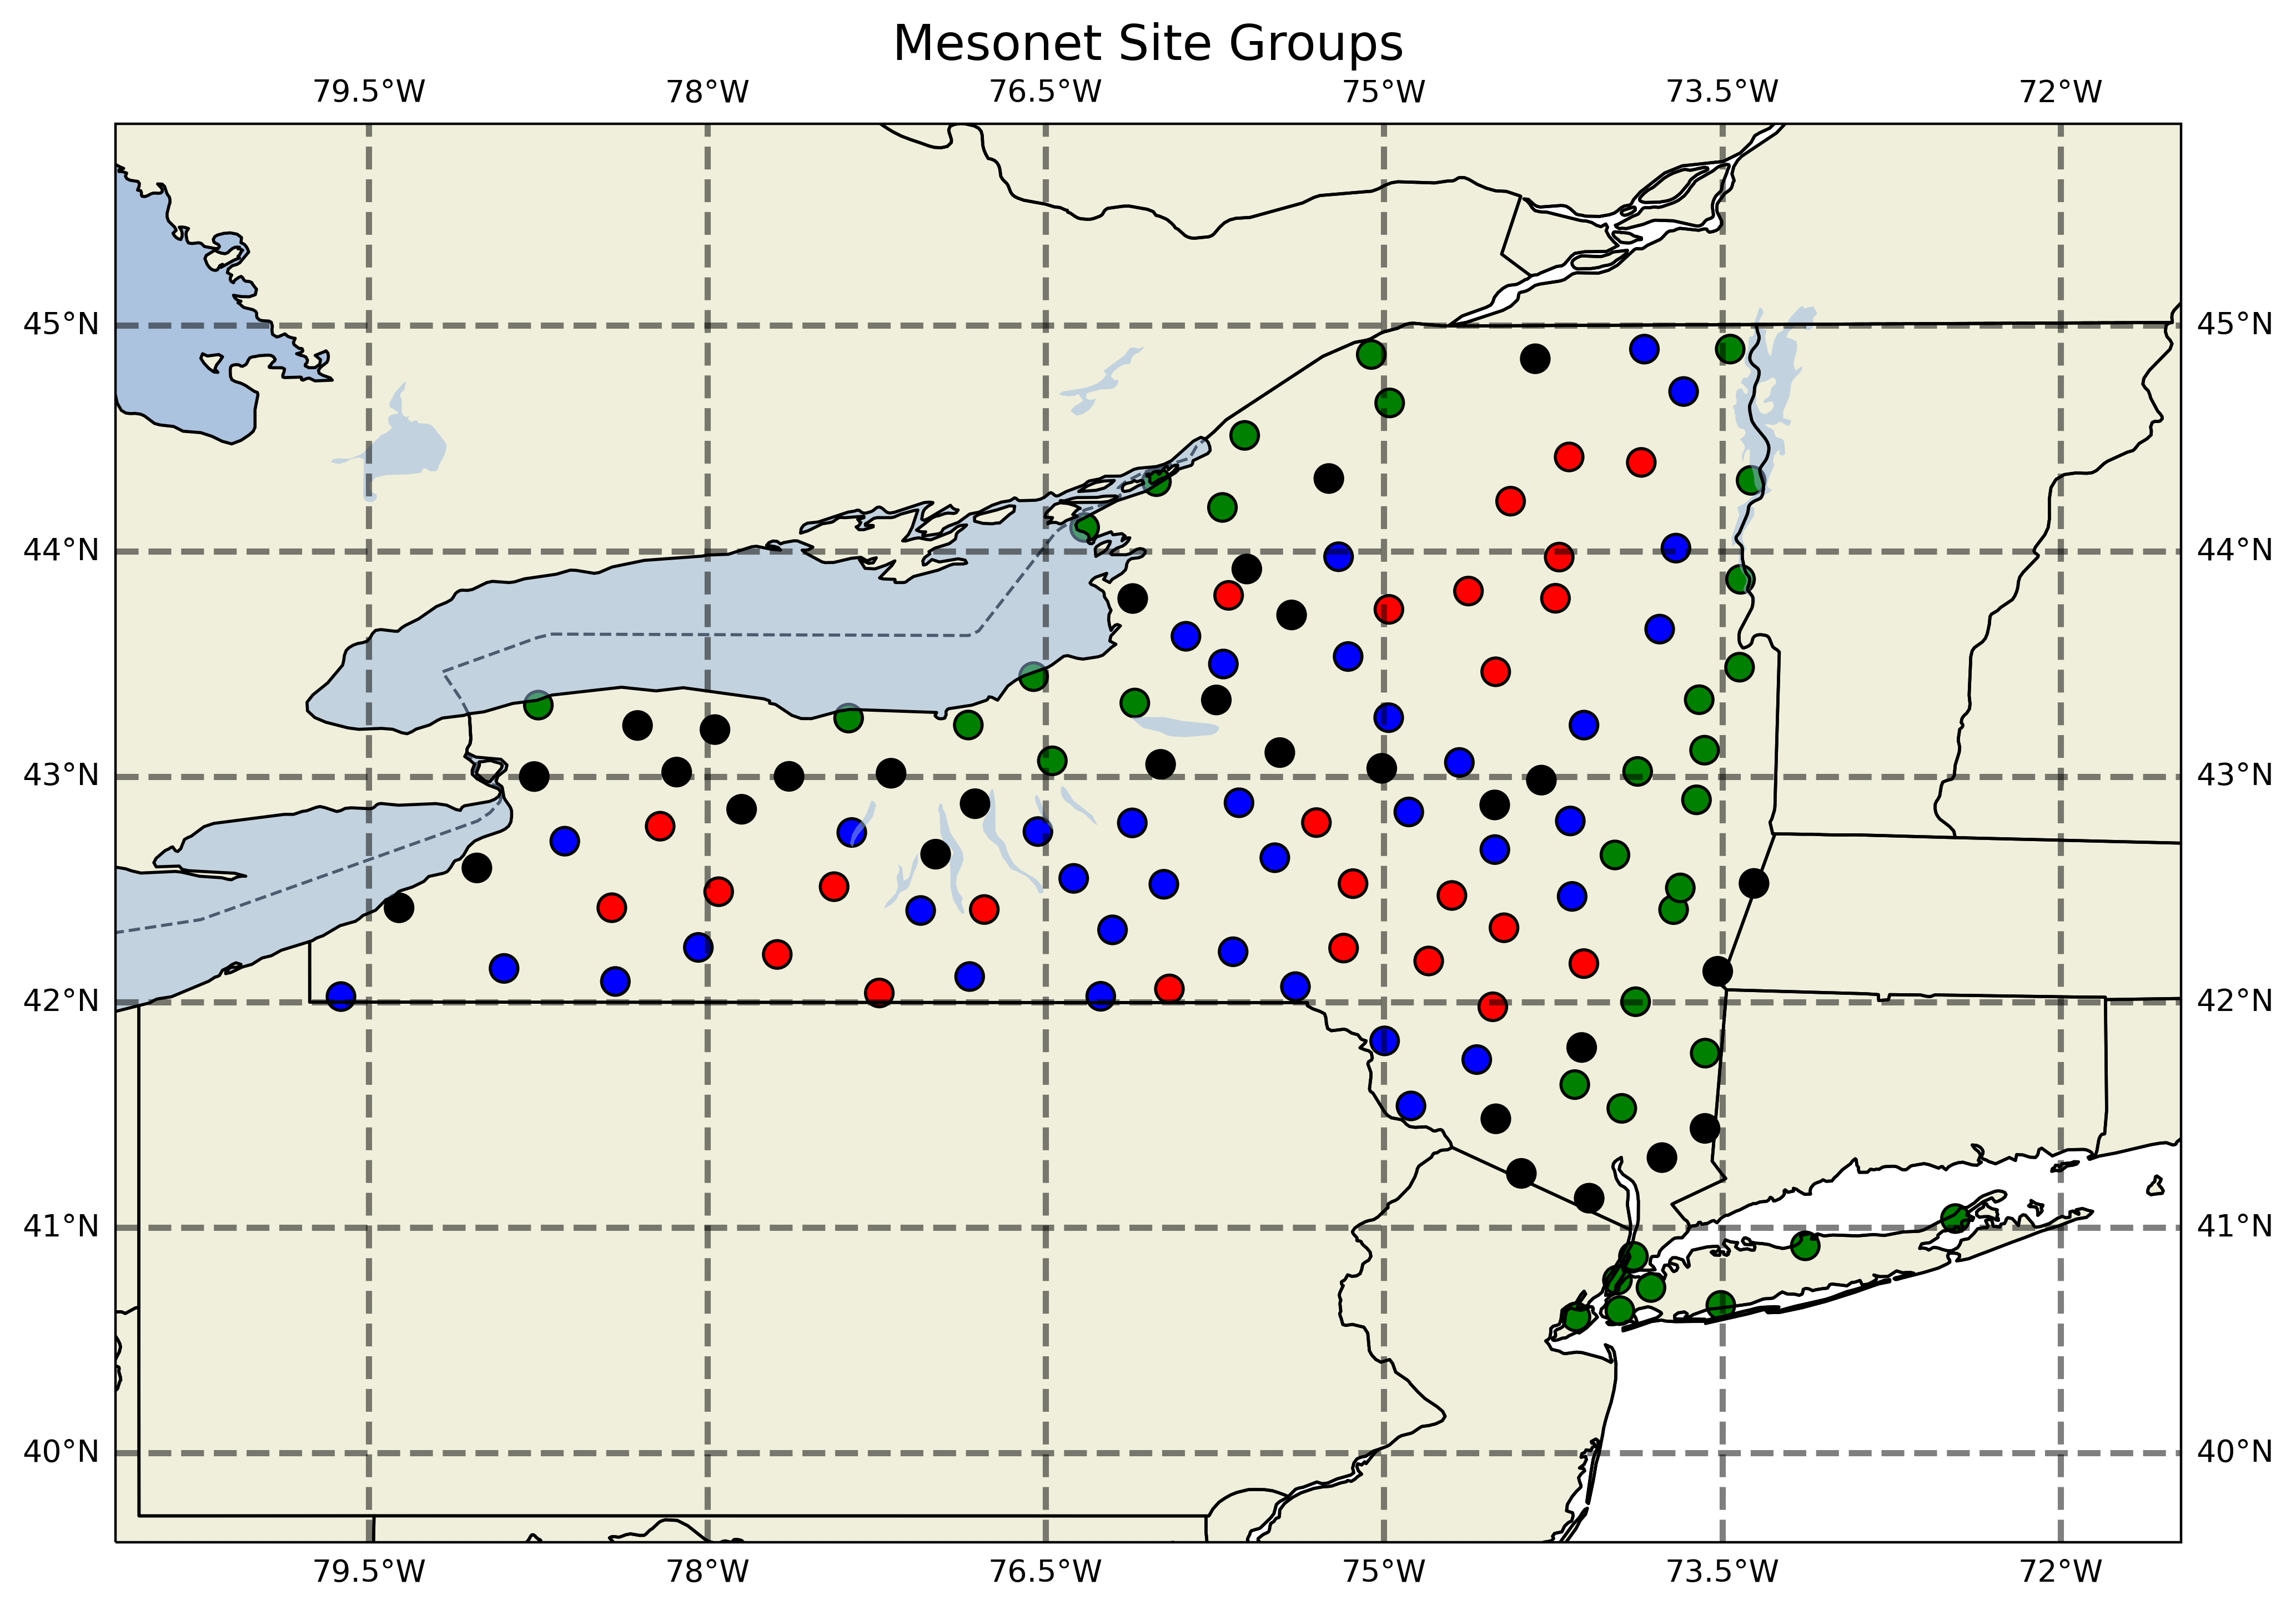

In [15]:
plurality_plot(pres_df)

# Wind Dir

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

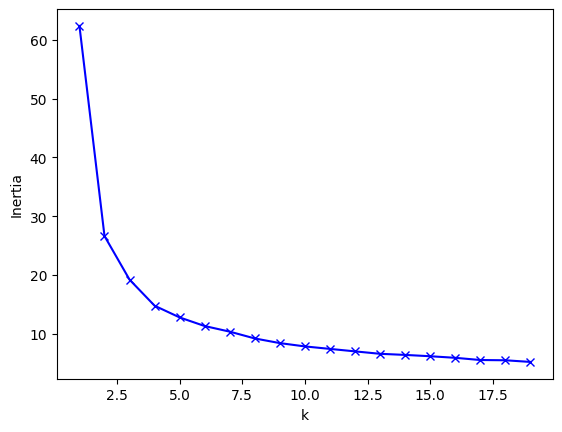

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
# wind direction
dir_df = main(gfs_fcast_and_error_df, "u_dir_nysm", 4)

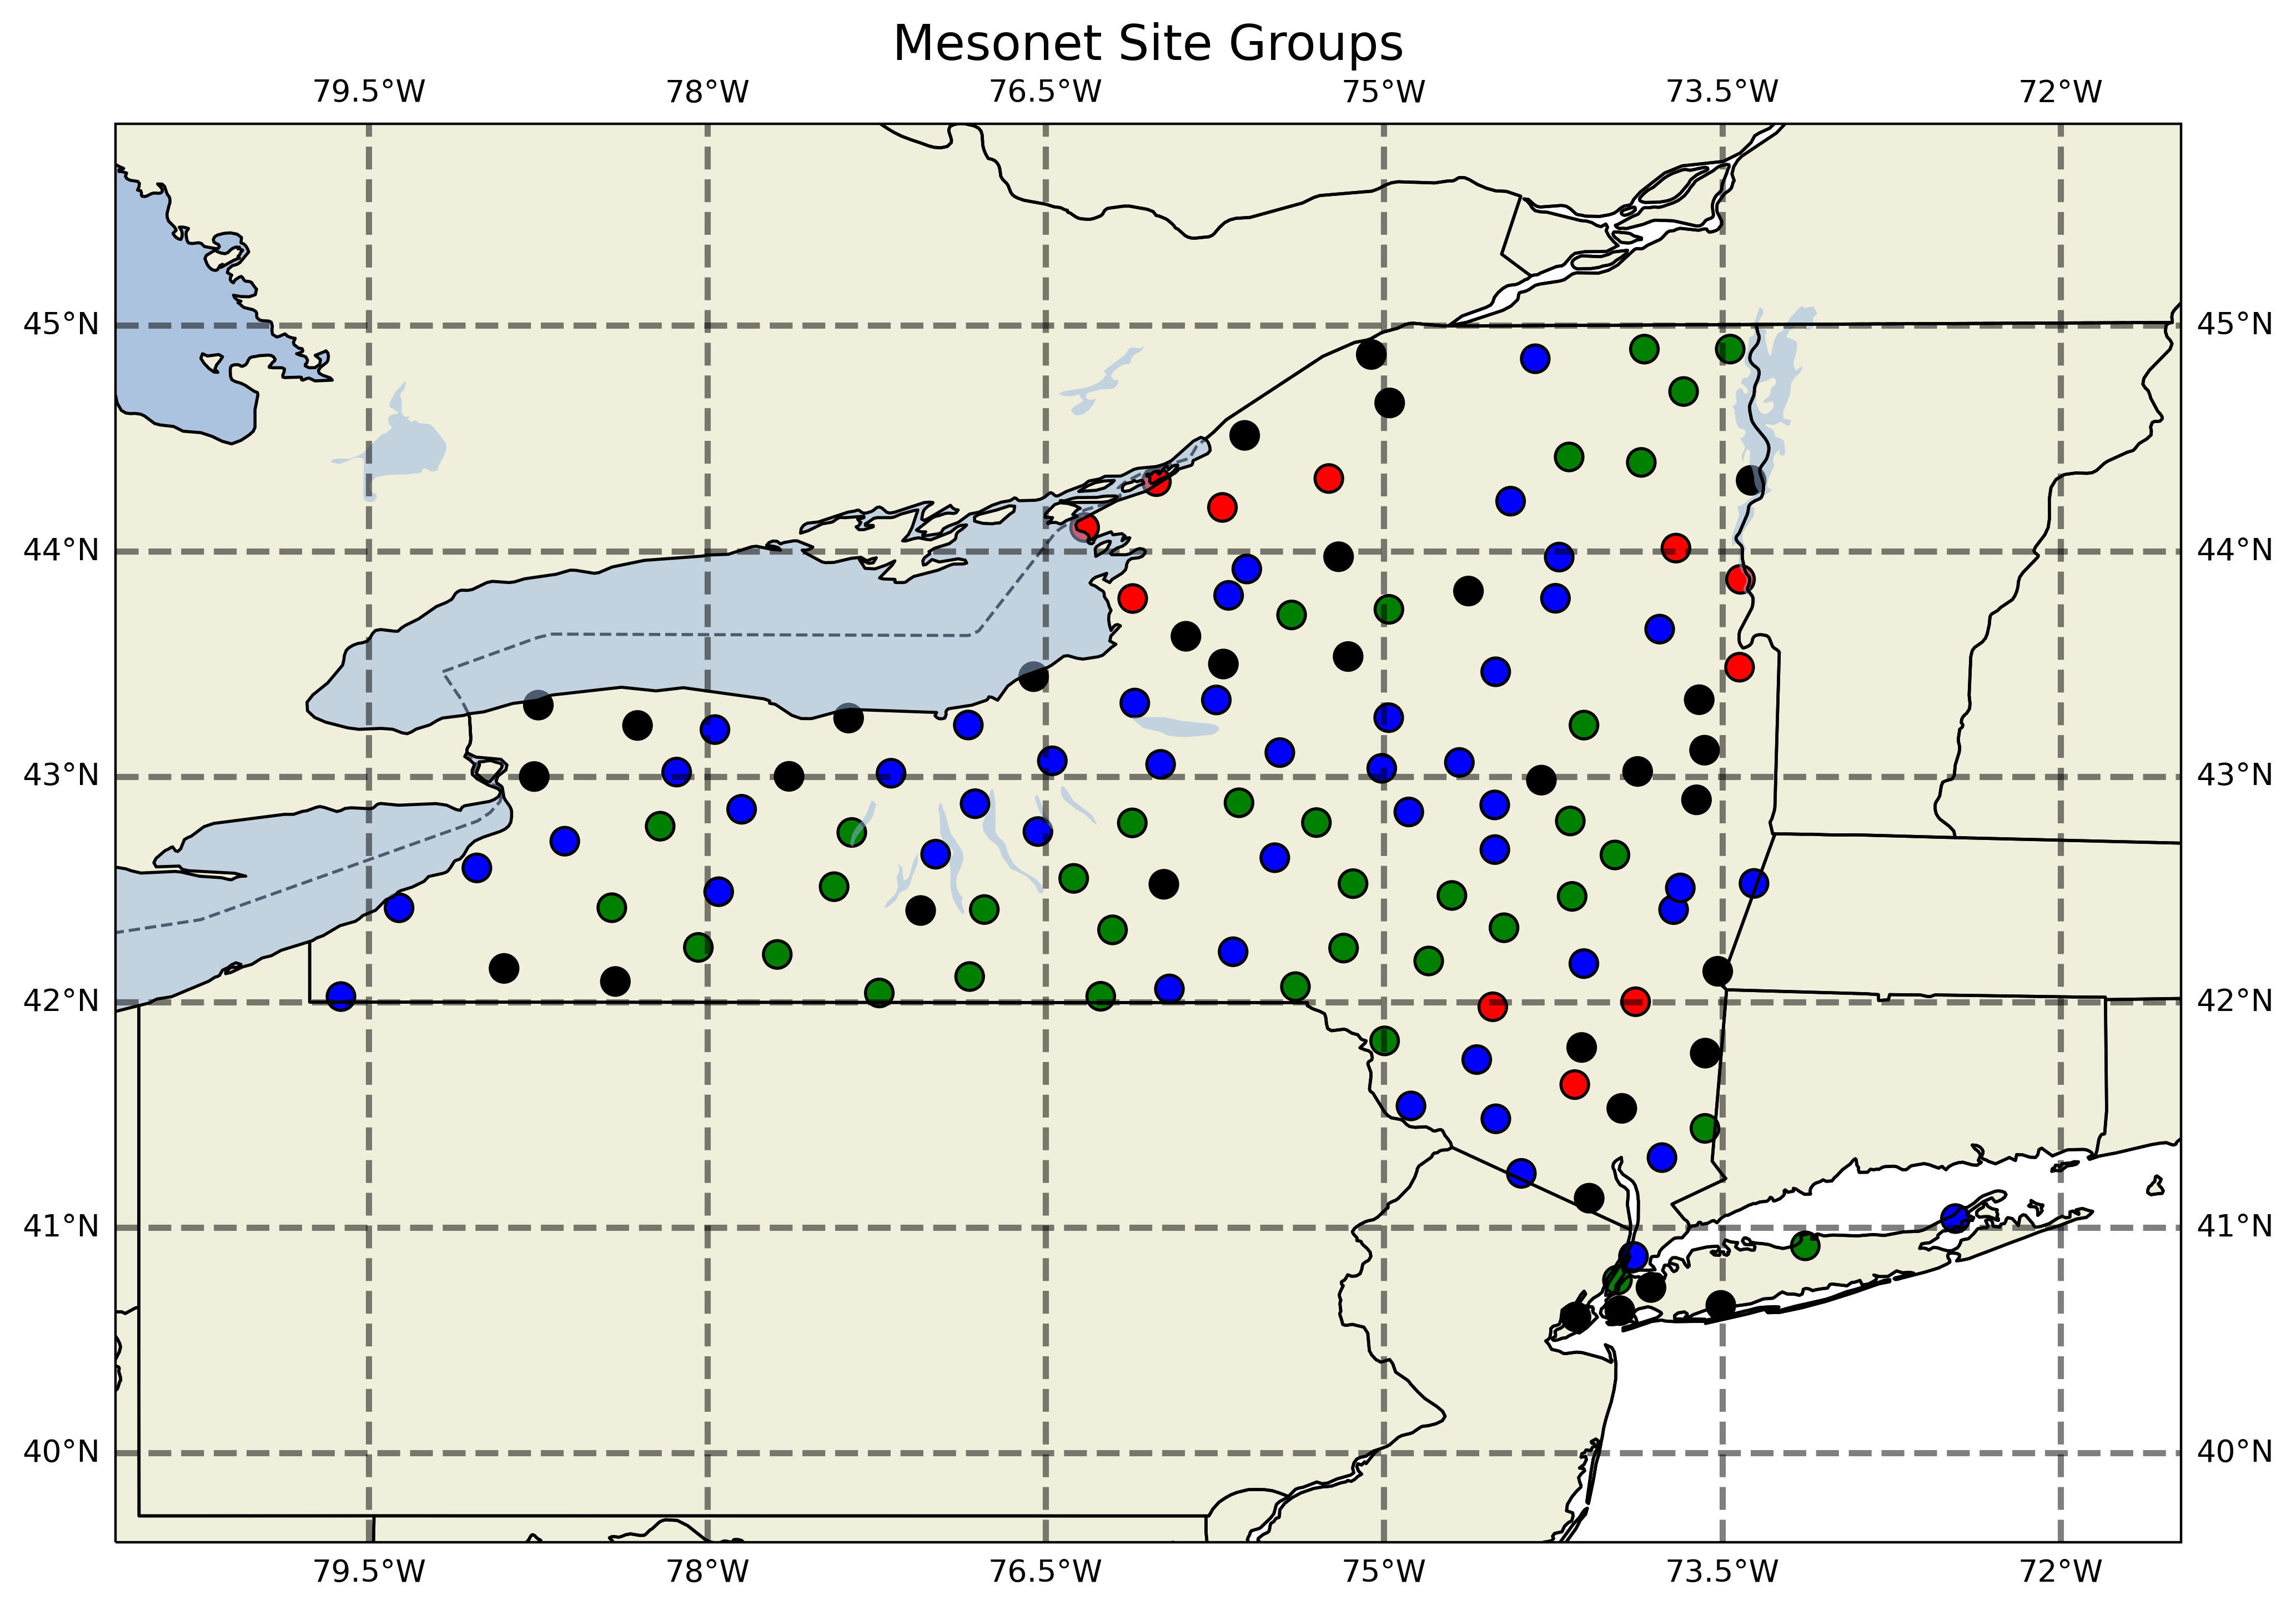

In [17]:
plurality_plot(dir_df)

# All met-vars combined

In [18]:
# Cluster on all weather data
# combine all dataframes
df = gfs_fcast_and_error_df.reset_index()
# get weather vars
precip_df = (
    df.groupby([df.time.dt.month, "station"])["new_tp_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
temp_df = (
    df.groupby([df.time.dt.month, "station"])["t2m_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
wind_df = (
    df.groupby([df.time.dt.month, "station"])["u_total_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
pres_df = (
    df.groupby([df.time.dt.month, "station"])["prmsl_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)
dir_df = (
    df.groupby([df.time.dt.month, "station"])["u_dir_nysm"]
    .mean()
    .to_frame()
    .reset_index()
)

# pivot dataframes
_precip = precip_df.pivot(index="station", columns="time", values="new_tp_nysm")
_temp = temp_df.pivot(index="station", columns="time", values="t2m_nysm")
_wind = wind_df.pivot(index="station", columns="time", values="u_total_nysm")
_pres = pres_df.pivot(index="station", columns="time", values="prmsl_nysm")
# _dir = dir_df.pivot(index = 'station', columns = 'time', values= 'u_dir_nysm')

In [19]:
# _dir

In [20]:
merged = _precip.merge(_temp, on="station")
merged = merged.merge(_wind, on="station")
merged = merged.merge(_pres, on="station")
# merged = merged.merge(_dir, on = 'station')

/tmp/tmp.DFFFW9Nfz1/ipykernel_1359341/2641563670.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'7_x', '1_x', '9_x', '3_x', '12_x', '2_x', '10_x', '5_x', '4_x', '11_x', '8_x', '6_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged = merged.merge(_pres, on="station")


In [21]:
aspect_df = pd.read_csv('/home/aevans/nwp_bias/src/correlation/data/aspect_nam.csv')
elev_df = pd.read_csv('/home/aevans/nwp_bias/src/correlation/data/elev_nam.csv')
lulc_df = pd.read_csv('/home/aevans/nwp_bias/src/correlation/data/nlcd_nam.csv')

In [22]:
merged = merged.merge(aspect_df, on="station")
merged = merged.merge(elev_df, on="station")
merged = merged.merge(lulc_df, on="station")

In [23]:
merged.keys()

Index(['station', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x',
       '9_x', '10_x', '11_x', '12_x', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
       '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '1_x', '2_x', '3_x', '4_x',
       '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '1_y', '2_y',
       '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y',
       'site_x', '19', '21_x', '24_x', '27', '28', '22_x', '23_x', '25', '26',
       '31_x', '33', '32', '34', '38', 'Unnamed: 0', 'elev', 'std', 'variance',
       'skew', 'med_dist', 'lon', 'lat', 'site_y', '11', '21_y', '22_y',
       '23_y', '24_y', '31_y', '41', '42', '43', '52', '71', '81', '82', '90',
       '95', '0'],
      dtype='object')

In [24]:
features = merged.copy()
features = features.reset_index()
stations = features["station"].tolist()

In [25]:
features = features.drop(columns=["station", "site_x", 'Unnamed: 0', 'site_y', '0'])
feastures = features.astype(float)
features.keys()

Index(['index', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x',
       '10_x', '11_x', '12_x', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y',
       '8_y', '9_y', '10_y', '11_y', '12_y', '1_x', '2_x', '3_x', '4_x', '5_x',
       '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '1_y', '2_y', '3_y',
       '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '19',
       '21_x', '24_x', '27', '28', '22_x', '23_x', '25', '26', '31_x', '33',
       '32', '34', '38', 'elev', 'std', 'variance', 'skew', 'med_dist', 'lon',
       'lat', '11', '21_y', '22_y', '23_y', '24_y', '31_y', '41', '42', '43',
       '52', '71', '81', '82', '90', '95'],
      dtype='object')

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/aevans/minicon

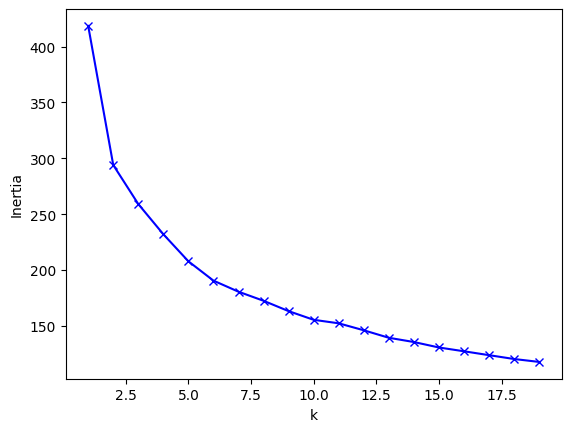

In [26]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(features)
# kmeans clustering
inertia = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, inertia, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [27]:
# let's say there are 6 clusters
# do actual cluster run
kmeans = KMeans(n_clusters=6).fit(features_normal)
labels = pd.DataFrame(
    kmeans.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledClasses = pd.concat((features, labels), axis=1)
labeledClasses = labeledClasses.rename({0: "labels"}, axis=1)
plot_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/notebooks/nysm_coords.csv")
plot_df["Cluster"] = labels
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

plot_df["color"] = plot_df["Cluster"].map(colordict)

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
plot_df

Unnamed: 0 station   latitude  longitude  Cluster   color
0             0    ADDI  42.040359 -77.237259        2   green
1             1    ANDE  42.182270 -74.801392        2   green
2             2    BATA  43.019939 -78.135658        0   black
3             3    BEAC  41.528751 -73.945267        5  yellow
4             4    BELD  42.223221 -75.668518        2   green
..          ...     ...        ...        ...      ...     ...
121         121    WFMB  44.393234 -73.858826        1    blue
122         122    WGAT  43.532410 -75.158600        1    blue
123         123    WHIT  43.485073 -73.423073        5  yellow
124         124    WOLC  43.228680 -76.842613        4  orange
125         125    YORK  42.855042 -77.847763        0   black

[126 rows x 6 columns]

In [29]:
# plot_df.to_csv("/home/aevans/nwp_bias/src/landtype/data/ny_met_geo_clusters.csv")

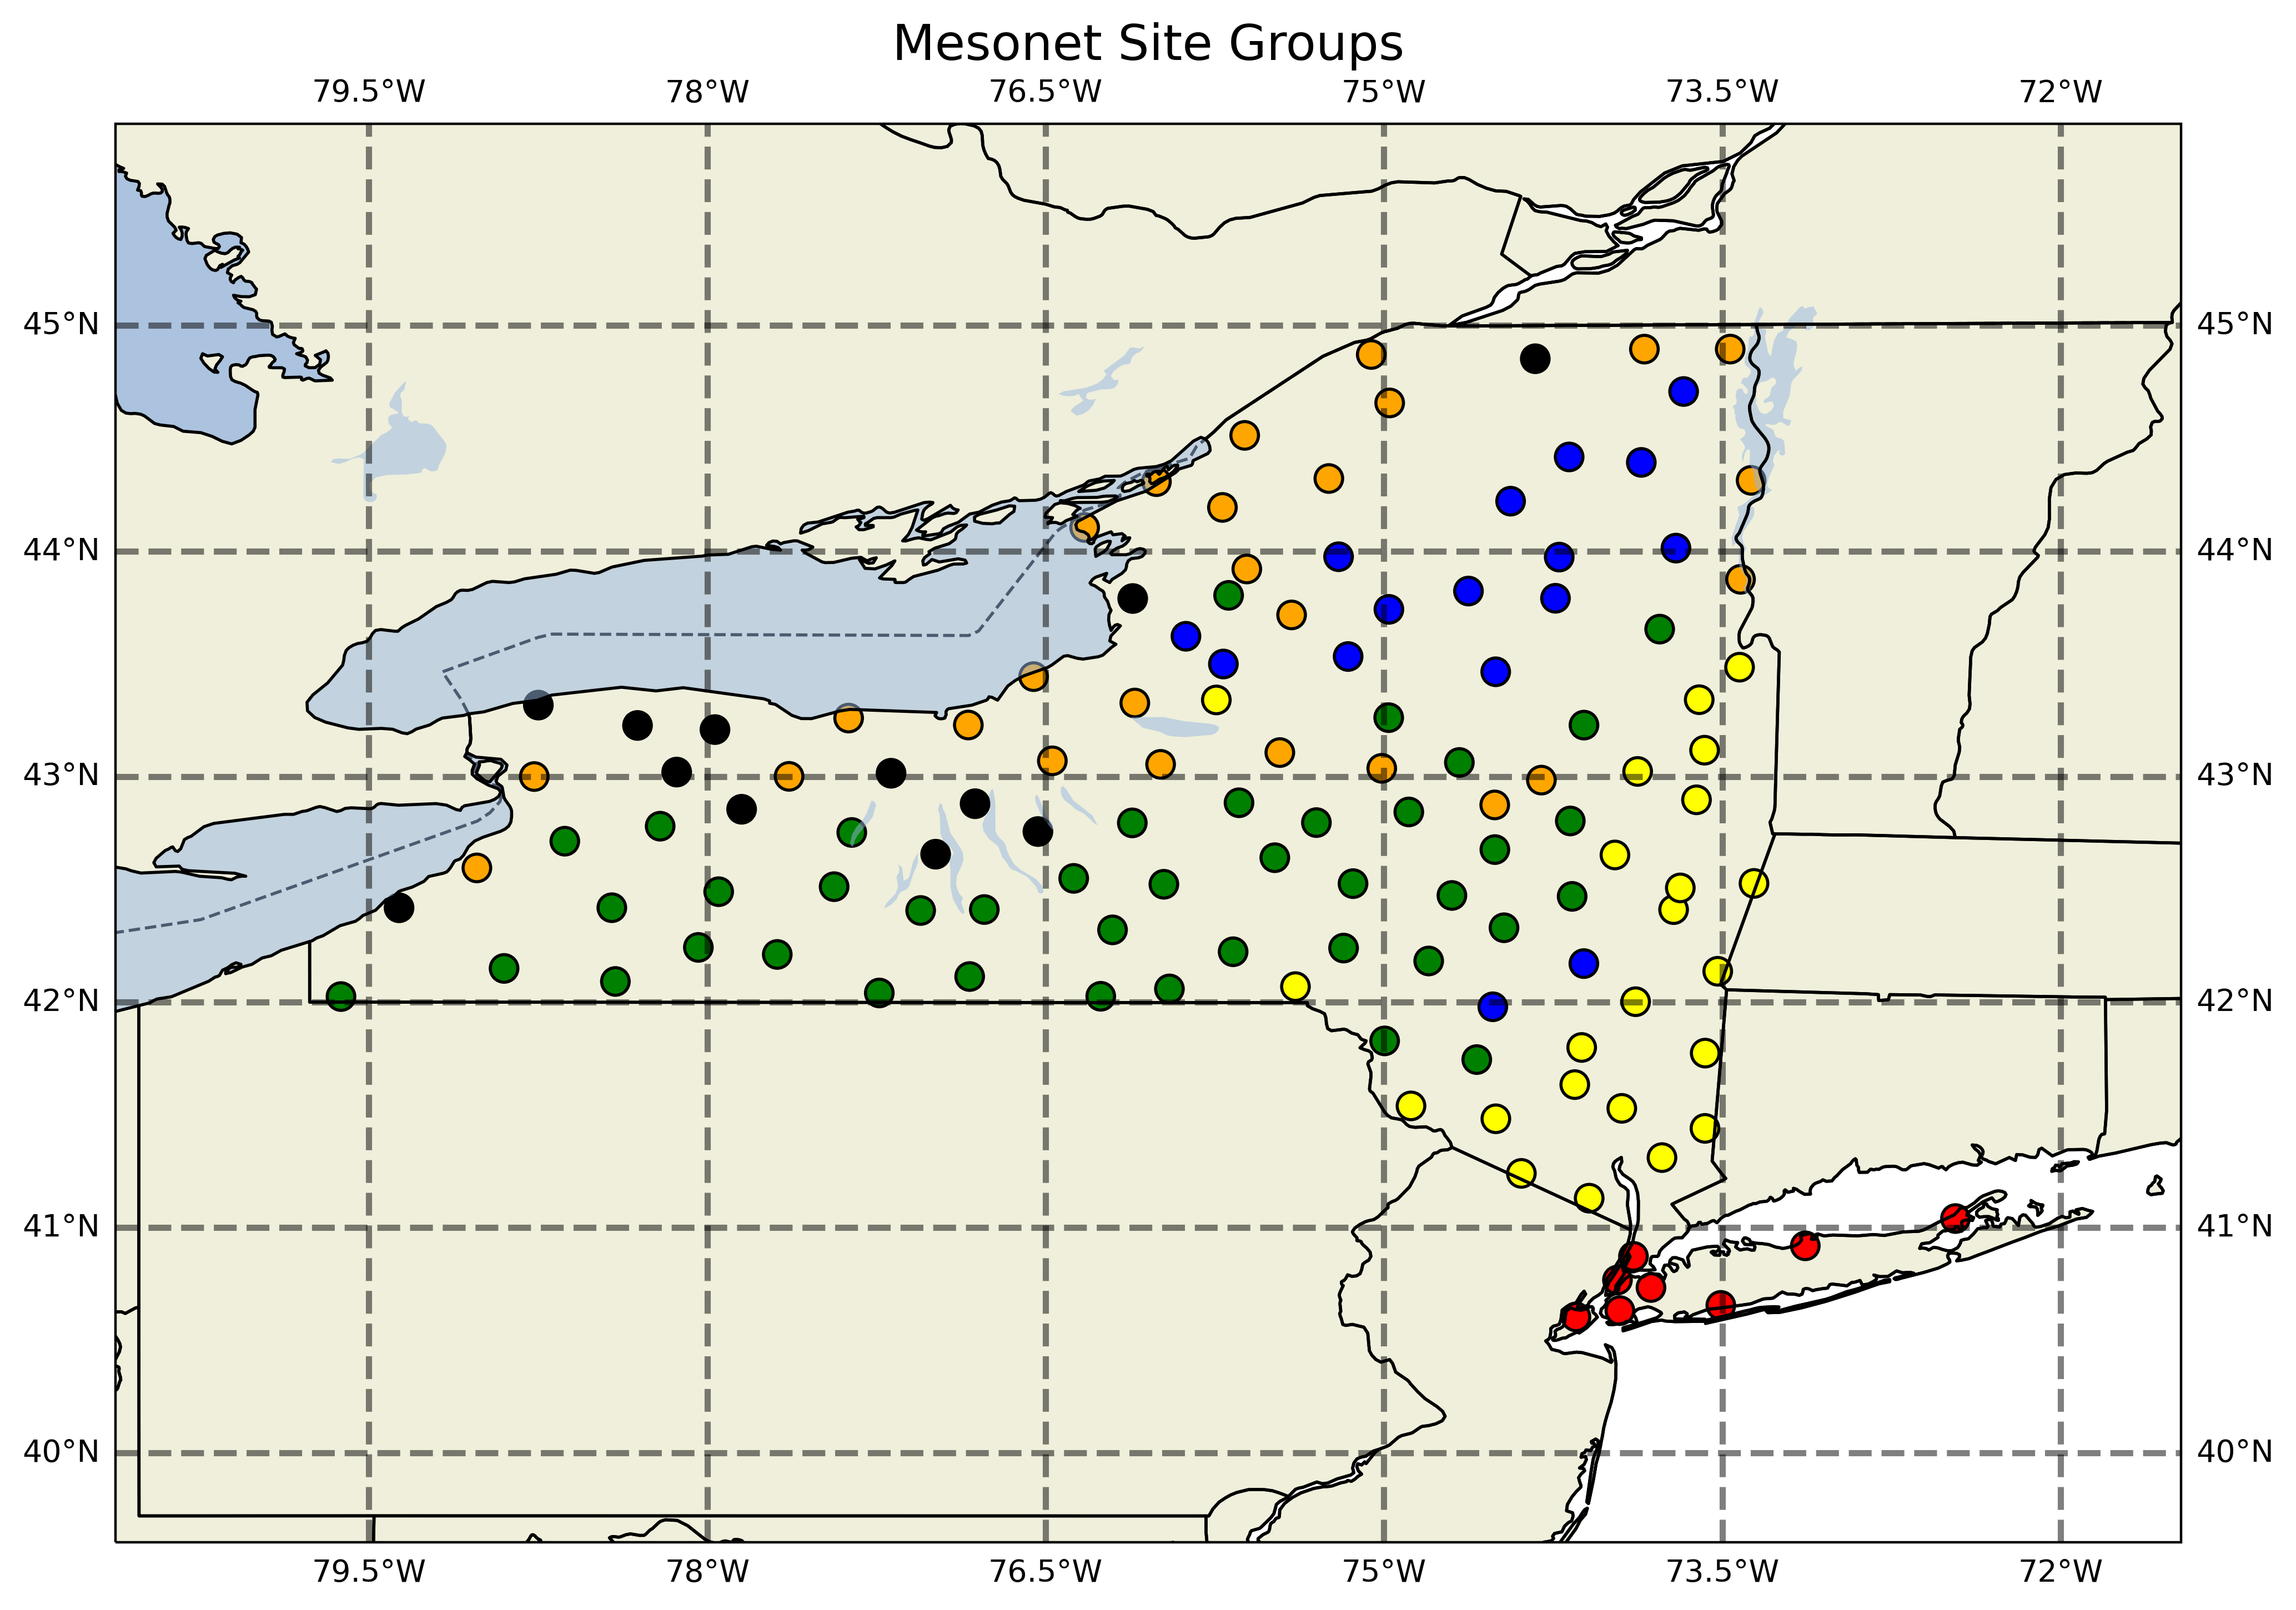

In [30]:
plurality_plot(plot_df)

In [31]:
from kmeans_interp.kmeans_feature_imp import KMeansInterp

kms = KMeansInterp(
    n_clusters=len(plot_df["Cluster"].unique()),
    random_state=1,
    ordered_feature_names=features.keys(),
    feature_importance_method="wcss_min",
).fit(features)
labels = kms.labels_
plot_df["Cluster"] = labels

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
centroids = kms.cluster_centers_
num_clusters = kms.n_clusters
n_features = kms.n_features_in_
centroids_labels = pd.DataFrame(
    {
        "centroid_dim": np.array(
            [centroids[i] for i in range(len(centroids))]
        ).flatten(),
        "cluster_label": np.array(
            [np.repeat(label, n_features) for label in range(num_clusters)]
        ).flatten(),
    }
)

In [33]:
centroids_labels[centroids_labels["cluster_label"] == 0]["centroid_dim"]

0     57.000000
1      0.313141
2      0.349641
3      0.268435
4      0.420459
        ...    
80     0.492503
81    18.335354
82     9.832991
83     6.338727
84     0.582637
Name: centroid_dim, Length: 85, dtype: float64

In [34]:
kms.feature_importances_[1][:-1]

[('variance', 59828.88265306123),
 ('9_y', 946.9599886610628),
 ('8_y', 945.1154459803557),
 ('7_y', 944.9372370377781),
 ('5_y', 943.9094970042393),
 ('10_y', 943.7208739623151),
 ('6_y', 942.8904460540899),
 ('11_y', 942.6827131181934),
 ('3_y', 942.4315555430416),
 ('2_y', 942.0727954881506),
 ('1_y', 941.2445793871609),
 ('12_y', 940.7654256241098),
 ('4_y', 939.6918740414962),
 ('med_dist', 659.197998046875),
 ('elev', 614.5989990234375),
 ('std', 245.69876189326143),
 ('index', 121.0),
 ('lon', 73.85882568359375),
 ('lat', 44.39323425292969),
 ('41', 39.01167556726384),
 ('42', 33.516916440503955),
 ('19', 25.0),
 ('23_x', 21.428571428571427),
 ('7_y', 20.30066541654874),
 ('8_y', 19.144547904161712),
 ('28', 18.75),
 ('6_y', 17.44059644173183),
 ('9_y', 14.714295875400072),
 ('43', 14.66171098394709),
 ('5_y', 12.550328040417064),
 ('10_y', 7.952895644387345),
 ('1_y', 7.424581138566488),
 ('24_x', 6.25),
 ('21_x', 6.25),
 ('33', 6.25),
 ('2_y', 5.634087338553047),
 ('27', 5.357

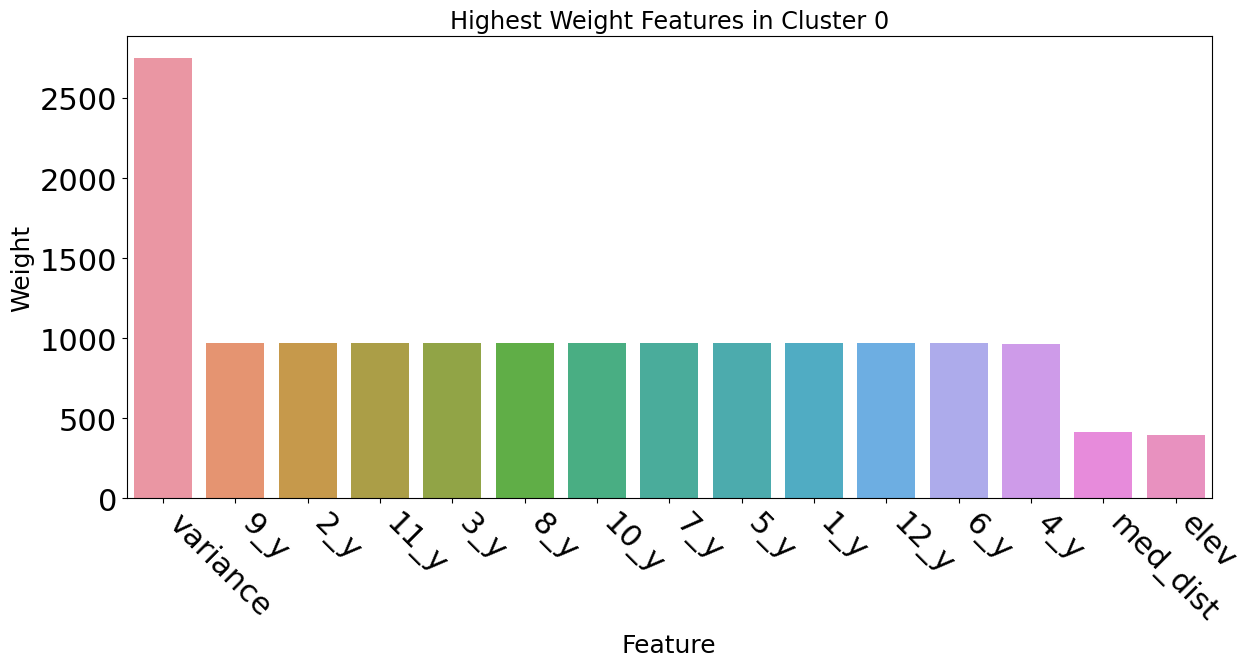

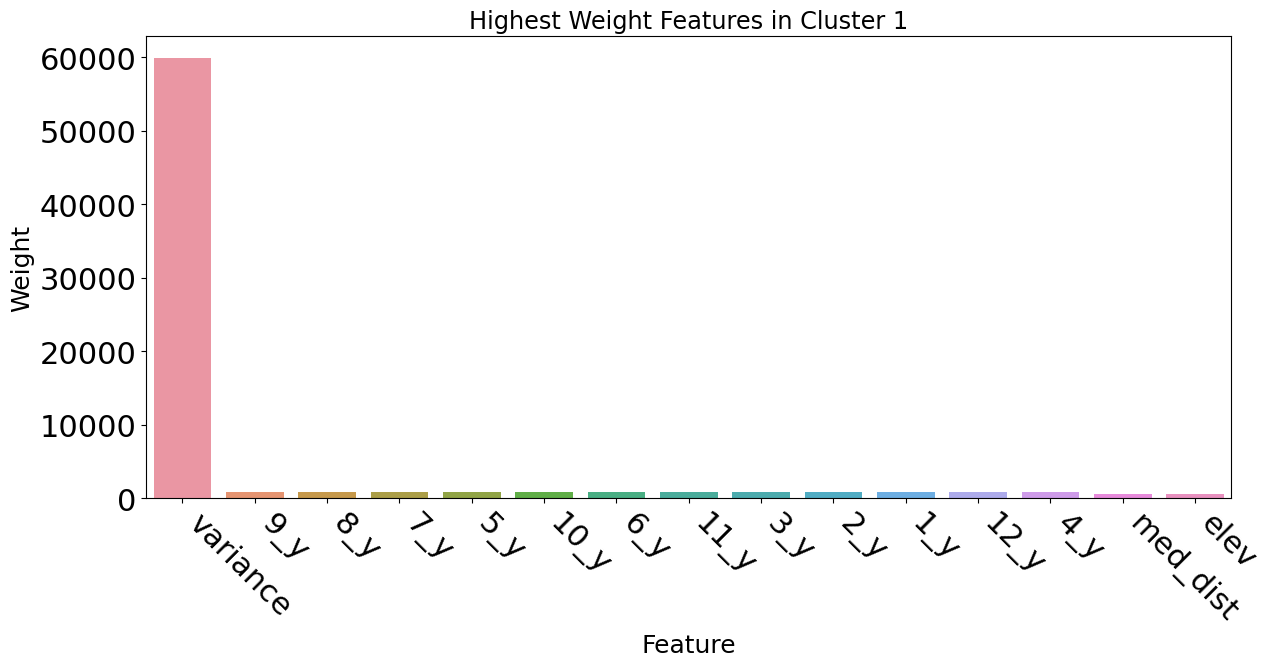

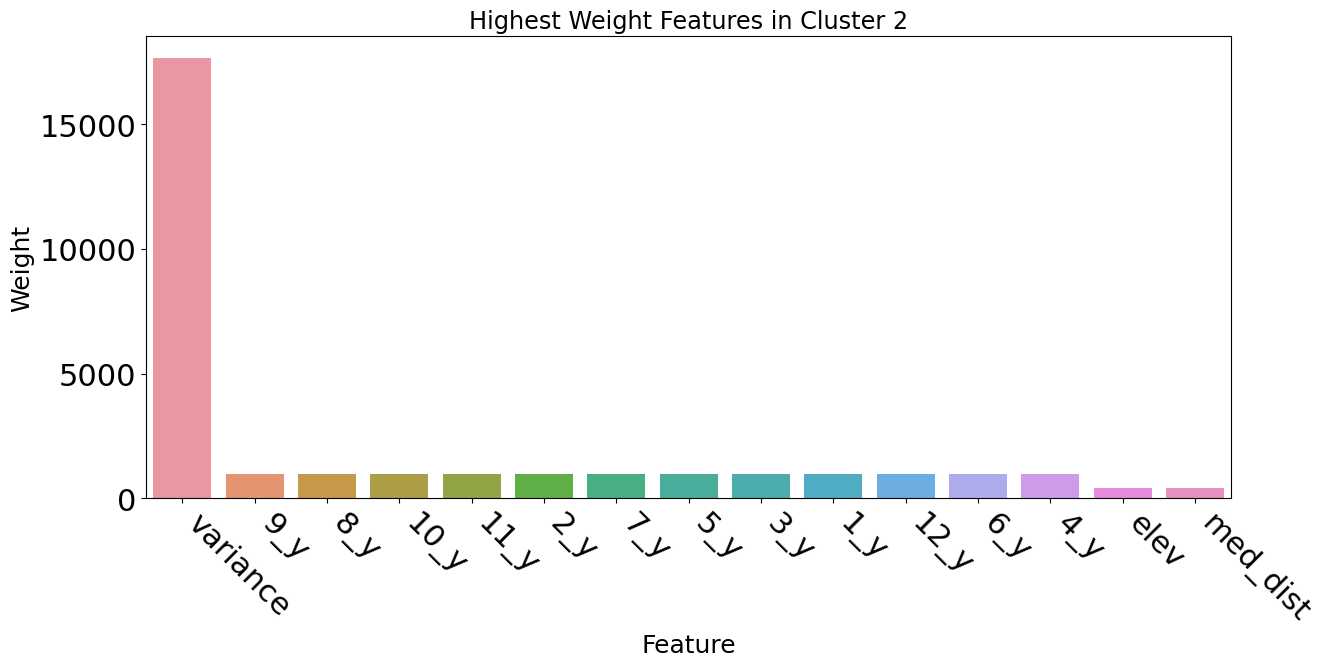

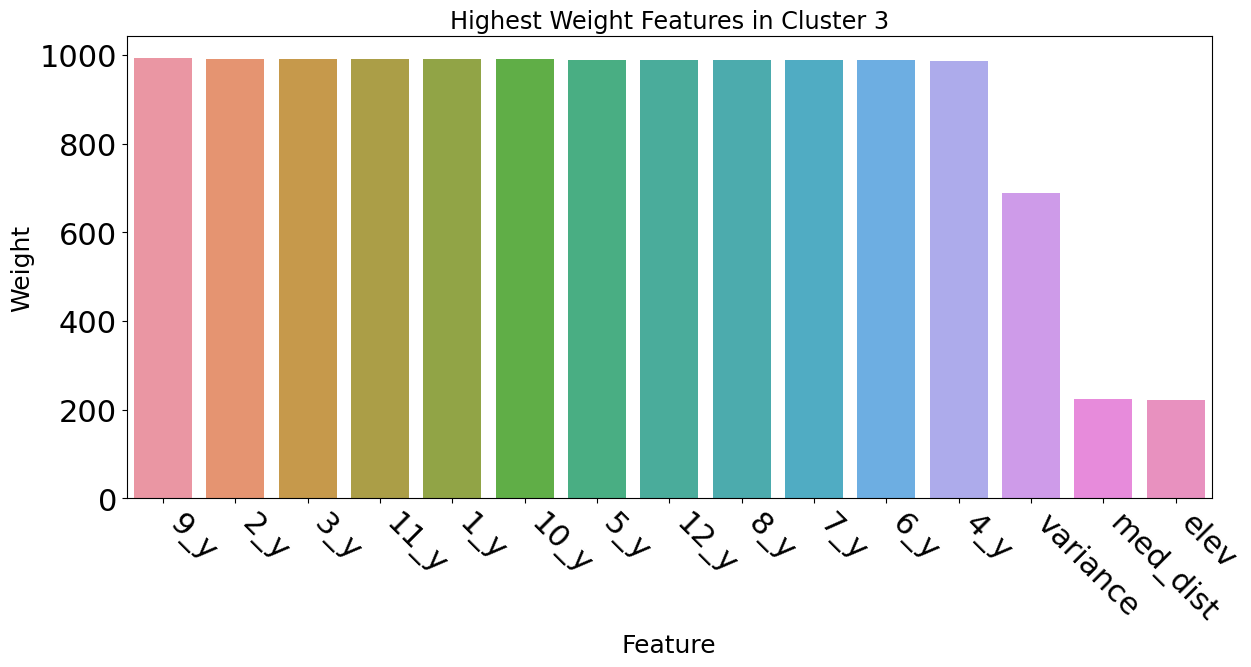

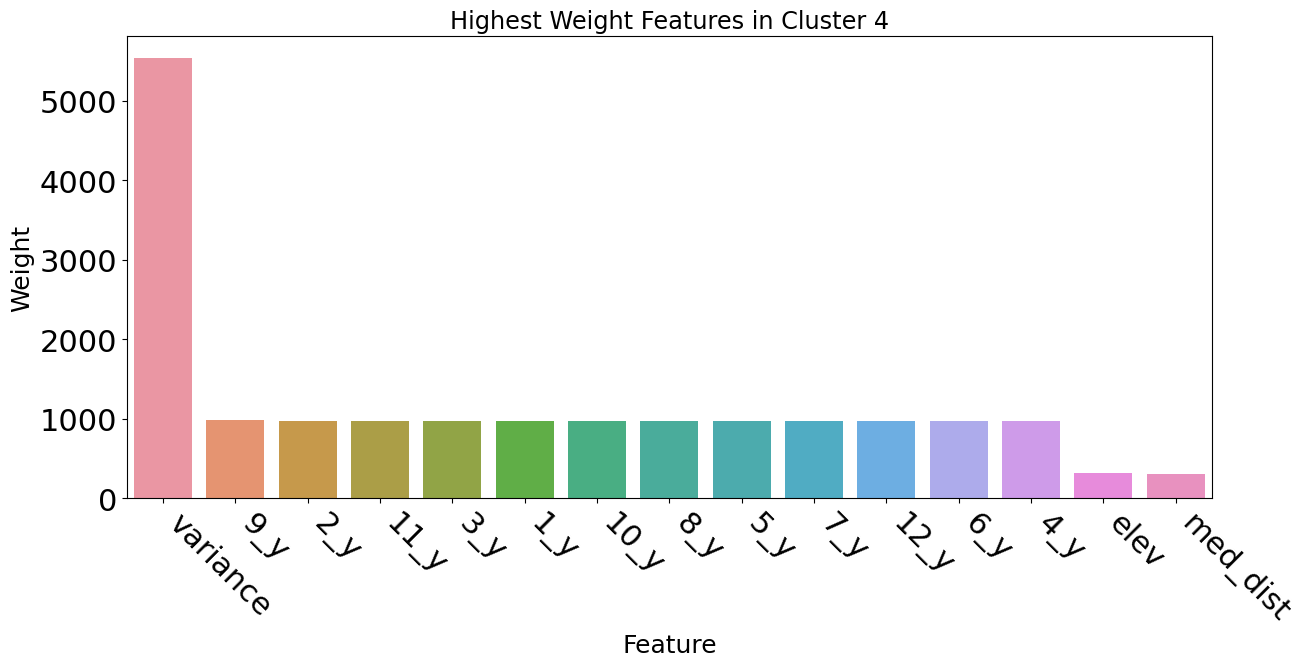

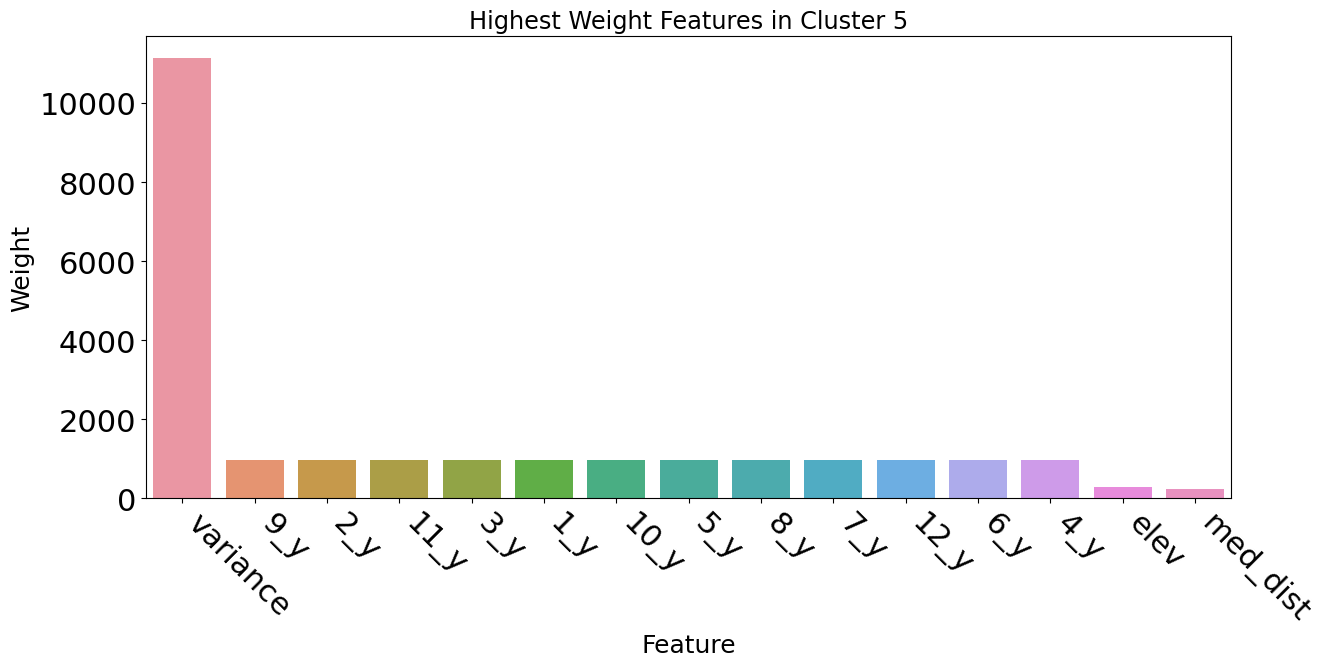

In [35]:
for cluster_label, feature_weights in kms.feature_importances_.items():
    df_feature_weight = pd.DataFrame(
        feature_weights[:15], columns=["Feature", "Weight"]
    )
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left")
    ax.tick_params(axis="both", which="major", labelsize=22)
    plt.title(
        f"Highest Weight Features in Cluster {cluster_label}", fontsize="xx-large"
    )
    plt.xlabel("Feature", fontsize=18)
    plt.ylabel("Weight", fontsize=18)

    plt.show()

    print("\n\n")